In [1]:
! pip install numpy pandas matplotlib wordcloud nltk scikit-learn textblob gensim imblearn demoji tensorflow keras seaborn transformers torch

In [2]:
import re
import demoji
import nltk
from nltk.tokenize import TweetTokenizer, sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import pandas as pd

nltk.download('punkt_tab') #tokenizzazione
nltk.download('stopwords') # stop words
nltk.download('wordnet') # lemmatizzazione
demoji.download_codes() # dizionario delle emoji

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/andreaiasenzaniro/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andreaiasenzaniro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andreaiasenzaniro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/var/folders/_y/cszqss6n29q_h8m3vt4b2lk80000gn/T/ipykernel_99722/4020399470.py:13: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes() # dizionario delle emoji


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# 1. Import dataset e Preprocessing

In [ ]:
# Verifichaimo se ci sono valori NaN nei commenti. Se sono pochi rimuoviamo le righe associate.

# Caricare il dataset (modifica il percorso se necessario)
file_path = "datasets/YoutubeCommentsDataSet.csv"
df = pd.read_csv(file_path)

# Controlla se ci sono valori NaN nella colonna "Comment"
print(f"Numero totale di commenti prima della rimozione: {len(df)}")
print(f"Valori NaN nella colonna Comment: {df['Comment'].isna().sum()}")

# Se ci sono NaN, rimuoverli
df = df.dropna(subset=['Comment'])
print(f"Numero totale di commenti dopo la rimozione: {len(df)}")

df.head()

Numero totale di commenti prima della rimozione: 18408
Valori NaN nella colonna Comment: 44
Numero totale di commenti dopo la rimozione: 18364


,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive


In [4]:
import re

# Lista di parole da contare
sexual_words = [
    "sex", "porn", "xxx", "nude", "explicit", "18+", "nsfw", "hardcore",
    "naked", "erotic", "fetish", "hot", "fuck", "bitch", "boobs",
    "dick", "pussy", "cock", "slut", "milf", "cum", "orgasm",
    "blowjob", "handjob", "deepthroat", "threesome", "gangbang",
    "stripper", "hooker", "escort", "camgirl", "sugar daddy",
    "bondage", "bdsm", "dominatrix", "kinky", "lick", "moan",
    "anal", "vibrator", "masturbation", "climax", "sex tape",
    "playboy", "sensual", "seduce", "twerking", "wet", "squirting",
    "penetration", "foreplay", "erogenous", "nipple", "lap dance",
    "thong", "lingerie", "panties", "semen", "horny", "aroused",
    "provocative", "breasts", "vagina", "penis", "buttocks",
    "oral sex", "oral action", "attractive", "seduction",
    "softcore", "hardcore", "deepfake", "taboo", "cunnilingus",
    "dominance", "submission", "degrading", "wet dream",
    "nude selfies", "sugar baby", "sexual fantasy"
]

violence_words = [
    "murder", "kill", "slaughter", "torture", "execute", "decapitate",
    "terrorist", "bomb", "massacre", "shoot", "gun", "rifle",
    "stabbing", "lynch", "assassinate", "bloodbath", "beheading",
    "strangle", "rape", "abuse", "assault", "harassment",
    "pedophile", "molestation", "kidnap", "hostage", "extortion",
    "death threat", "violence", "riot", "fight", "attack",
    "mugging", "aggression", "choke", "punch", "stab", "burn",
    "hang", "drown", "brutal", "mutilation", "genocide",
    "suffocate", "savage", "blood", "gore", "brutality",
    "war crime", "child abuse", "animal abuse", "executed",
    "tied up", "psychopath", "serial killer", "homicide",
    "strangulation", "cruel", "sadistic", "deadly", "hatred",
    "threat", "beaten", "burned alive", "gunned down",
    "assaulted", "violated", "warzone", "dismember",
    "disfigure", "tortured", "violent", "corpses"
]

words_to_count = violence_words + sexual_words
comment_count = df["Comment"].astype(str).apply(lambda comment: any(re.search(rf"\b{re.escape(word)}\b", comment, re.IGNORECASE) for word in words_to_count)).sum()
print(f"Numero di commenti contenenti almeno una parola della lista: {comment_count}")

Numero di commenti contenenti almeno una parola della lista: 441


## Preprocessing

In [5]:
# =========================
# **1️⃣ Espansione delle contrazioni e slang**
# =========================
CONTRACTIONS_DICT = {
    "don't": "do not", "doesn't": "does not", "didn't": "did not",
    "won't": "will not", "can't": "cannot", "i'm": "i am", "you're": "you are",
    "it's": "it is", "they're": "they are", "we're": "we are", "isn't": "is not",
    "aren't": "are not", "haven't": "have not", "hasn't": "has not",
    "wasn't": "was not", "weren't": "were not", "shouldn't": "should not",
    "wouldn't": "would not", "couldn't": "could not", "mustn't": "must not"
}

SLANG_DICT = {
    "nude": "naked", "xxx": "porn", "tits": "breasts", "dick": "penis",
    "pussy": "vagina", "bj": "blowjob", "cum": "semen", "hornyk": "aroused",
    "milf": "attractive older woman", "nsfw": "not safe for work",
    "thirsty": "sexually desperate", "ass": "buttocks", "booty": "buttocks",
    "deepthroat": "oral sex", "suck": "oral action", "sexy": "attractive"
}

def expand_contractions_and_slang(text):
    """Espande le contrazioni e sostituisce lo slang con termini standard."""
    for key, value in {**CONTRACTIONS_DICT, **SLANG_DICT}.items():
        text = re.sub(r"\b" + key + r"\b", value, text)
    return text

# =========================
# **2️⃣ Correzione ortografica**
# =========================
def correct_spelling(text):
    """Corregge gli errori ortografici usando TextBlob."""
    return str(TextBlob(text).correct())

# =========================
# **3️⃣ Segmentazione delle frasi**
# =========================
def segment_sentences(text):
    """Divide il testo in frasi separate."""
    return sent_tokenize(text) if isinstance(text, str) else []

# =========================
# **4️⃣ Gestione delle emoji e simboli ASCII**
# =========================
EMOJI_DICT = {
    "😊": "happy", "😂": "laugh", "😢": "sad", "😡": "angry", "😍": "love",
    "😎": "cool", "👍": "positive", "👎": "negative", "🔥": "exciting",
    "🚀": "fast", "🎉": "celebration", "💯": "perfect", "🙏": "thankful",
    "🤔": "thinking", "😭": "crying", "😴": "sleepy", "😆": "funny",
    "🥳": "party", "💪": "strong", "🤗": "hug", "🥺": "emotional", "❤️": "love",
    "💔": "heartbroken", "🤬": "furious", "🤯": "mindblown", "😇": "innocent",
    "👀": "looking", "🤓": "nerd", "🤤": "drooling", "🤡": "clown"
}

def replace_emojis_and_ascii(text):
    """Sostituisce le emoji con parole e gestisce simboli ASCII comuni."""
    for emoji, meaning in EMOJI_DICT.items():
        text = text.replace(emoji, f" {meaning} ")
    text = demoji.replace(text, lambda x: f" {demoji.replace(x)} ")

    # Rileva e rimuove simboli ASCII sospetti
    text = re.sub(r'(\*\*|\*\w+\*|\W+\*{2,})', '', text)  # Rimuove **testo** o *testo*
    text = re.sub(r'(\bxx+\b)', 'explicit', text)  # Rileva "xxx", "xx"

    return text

# =========================
# **5️⃣ Rimozione Stop Words (personalizzata)**
# =========================
important_stopwords = {"not", "no", "nor", "n't", "never", "hardly", "barely", "scarcely",
                       "very", "really", "so", "extremely", "super", "terribly", "horribly",
                       "awfully", "slightly", "somewhat", "but", "however", "although",
                       "though", "yet", "i", "we", "you", "he", "she", "they", "my", "your",
                       "why", "how", "what"}

stop_words = set(stopwords.words("english")) - important_stopwords

# =========================
# **6️⃣ Funzione di Preprocessing Generale**
# =========================
def preprocess_text(text):
    """Esegue il preprocessing completo di un testo per adult content filtering."""
    if isinstance(text, str):
        # 1. Converti il testo in minuscolo
        text = text.lower()

        # 2. Espansione di contrazioni e slang
        text = expand_contractions_and_slang(text)

        # 3. Rimozione di URL e menzioni (@username, #hashtag)
        text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
        text = re.sub(r"@\w+|#\w+", "", text)

        # 4. Gestione delle emoji e simboli ASCII
        text = replace_emojis_and_ascii(text)

        # 5. Rimozione di caratteri speciali e markup
        text = re.sub(r"[^a-z\s]", "", text)

        # 6. Tokenizzazione con TweetTokenizer
        tokenizer = TweetTokenizer()
        tokens = tokenizer.tokenize(text)

        # 7. Rimozione delle stop words
        tokens = [word for word in tokens if word not in stop_words]

        # 8. Lemmatizzazione
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

        # 9. Correzione ortografica
        text = correct_spelling(" ".join(tokens))

        return text
    return ""

## Apply preprocessing

In [ ]:
# Applicazione del preprocessamento e della segmentazione
df['Segmented_Comments'] = df['Comment'].apply(segment_sentences)
df['Processed_Comment'] = df['Comment'].apply(preprocess_text)

# Visualizzare alcune righe del dataset preprocessato
df.head()

In [ ]:
# Salvataggio del dataset preprocessato in formato Pickle
df.to_pickle("datasets/Preprocessed_YoutubeComments_ACF.pkl")
print("Dataset salvato in formato Pickle!")

In [ ]:
# Caricamento del dataset preprocessato da Pickle
path_pickle = "datasets/Preprocessed_YoutubeComments_ACF.pkl"

df = pd.read_pickle(path_pickle)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18364 entries, 0 to 18407
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Comment             18364 non-null  object
 1   Sentiment           18364 non-null  object
 2   Segmented_Comments  18364 non-null  object
 3   Processed_Comment   18364 non-null  object
dtypes: object(4)
memory usage: 717.3+ KB


# Dataset Labeling

In [ ]:
import re

# Unione delle liste di parole chiave
words_to_count = sexual_words + violence_words

# Funzione per verificare se un commento contiene parole sensibili
def classify_comment(comment):
    if any(re.search(rf"\b{re.escape(word)}\b", str(comment), re.IGNORECASE) for word in words_to_count):
        return 1  # Classifica come "adult"
    else:
        return 0  # Classifica come "safe"

# 📌 Applicare la classificazione ai commenti
df['Content_Label'] = df['Processed_Comment'].apply(classify_comment)

# 📌 Controllare la distribuzione delle classi
print(df['Content_Label'].value_counts())
df.info()

Content_Label
0    17816
1      548
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 18364 entries, 0 to 18407
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Comment             18364 non-null  object
 1   Sentiment           18364 non-null  object
 2   Segmented_Comments  18364 non-null  object
 3   Processed_Comment   18364 non-null  object
 4   Content_Label       18364 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 860.8+ KB


## Class balancing

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

# 📌 Controllare la distribuzione iniziale delle classi
class_counts = df['Content_Label'].value_counts()
print("🔹 Distribuzione originale delle classi:\n", class_counts)

# 📌 Definire il rapporto 60%-40%
total_adult = class_counts[1]  # Numero di campioni "adult"
total_safe = class_counts[0]  # Numero di campioni "safe"

# 📌 Calcolare quanti "safe" dobbiamo mantenere per avere 60%-40%
target_safe = int(total_adult * (60 / 40))  # Safe deve essere 1.5 volte il numero di "adult"

# 📌 Se il numero di "safe" è maggiore del target, facciamo downsampling
if total_safe > target_safe:
    undersampler = RandomUnderSampler(sampling_strategy={0: target_safe}, random_state=42)
    x_balanced, y_balanced = undersampler.fit_resample(df, df['Content_Label'])

    # 📌 Controllare la distribuzione DOPO il downsampling
    print("\n🔹 Distribuzione delle classi DOPO il downsampling:\n", pd.Series(y_balanced).value_counts())

    # 📌 Creare un nuovo DataFrame con i dati bilanciati
    df_balanced = pd.DataFrame(x_balanced)
else:
    df_balanced = df  # Se già bilanciato, usa il dataset originale

🔹 Distribuzione originale delle classi:
 Content_Label
0    17816
1      548
Name: count, dtype: int64

🔹 Distribuzione delle classi DOPO il downsampling:
 Content_Label
0    822
1    548
Name: count, dtype: int64


# Model training

🔹 Using device: cuda
🔹 Distribuzione delle classi dopo il bilanciamento:
 Content_Label
0    822
1    548
Name: count, dtype: int64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 69/69 [00:14<00:00,  4.76it/s, acc=0.601, loss=0.744]



🔹 Epoch 1: Training Loss: 0.6713, Training Accuracy: 0.6013
🔹 Validation Loss: 0.6731, Validation Accuracy: 0.5401


Epoch 2: 100%|██████████| 69/69 [00:14<00:00,  4.65it/s, acc=0.615, loss=0.689]



🔹 Epoch 2: Training Loss: 0.6446, Training Accuracy: 0.6150
🔹 Validation Loss: 0.6190, Validation Accuracy: 0.7117


Epoch 3: 100%|██████████| 69/69 [00:14<00:00,  4.69it/s, acc=0.692, loss=0.775]



🔹 Epoch 3: Training Loss: 0.6168, Training Accuracy: 0.6916
🔹 Validation Loss: 0.5850, Validation Accuracy: 0.7299


Epoch 4: 100%|██████████| 69/69 [00:14<00:00,  4.78it/s, acc=0.732, loss=0.684]



🔹 Epoch 4: Training Loss: 0.5721, Training Accuracy: 0.7318
🔹 Validation Loss: 0.5448, Validation Accuracy: 0.7518


Epoch 5: 100%|██████████| 69/69 [00:14<00:00,  4.81it/s, acc=0.714, loss=0.55]



🔹 Epoch 5: Training Loss: 0.5572, Training Accuracy: 0.7144
🔹 Validation Loss: 0.4911, Validation Accuracy: 0.7774


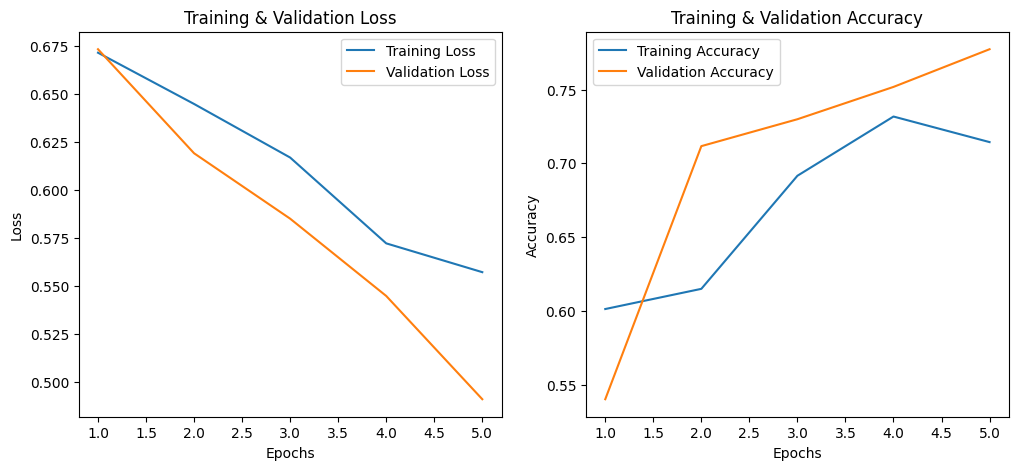

   Epoch  Training Loss  Training Accuracy  Validation Loss  \
0      1         0.6713             0.6013           0.6731   
1      2         0.6446             0.6150           0.6190   
2      3         0.6168             0.6916           0.5850   
3      4         0.5721             0.7318           0.5448   
4      5         0.5572             0.7144           0.4911   

   Validation Accuracy  
0               0.5401  
1               0.7117  
2               0.7299  
3               0.7518  
4               0.7774  


In [ ]:
import torch
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import classification_report

# 📌 Controllare il dispositivo (GPU CUDA o MPS su Mac)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"🔹 Using device: {device}")

# 📌 Verificare la distribuzione delle classi dopo il bilanciamento
print("🔹 Distribuzione delle classi dopo il bilanciamento:\n", df_balanced['Content_Label'].value_counts())

# 📌 Suddividere il dataset in training e test (80%-20%)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_balanced['Processed_Comment'].tolist(), df_balanced['Content_Label'].tolist(),
    test_size=0.2, stratify=df_balanced['Content_Label'], random_state=42
)

# 📌 Caricare il Tokenizer di BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 📌 Tokenizzare i testi per BERT
train_encodings = tokenizer(train_texts, truncation=True, padding='max_length', max_length=70, return_tensors='pt')
test_encodings = tokenizer(test_texts, truncation=True, padding='max_length', max_length=70, return_tensors='pt')

# 📌 **Creare Dataset PyTorch**
class ContentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = ContentDataset(train_encodings, train_labels)
test_dataset = ContentDataset(test_encodings, test_labels)

# 📌 **Configurare il modello BERT**
config = BertConfig.from_pretrained(
    "bert-base-uncased",
    num_labels=2,  # 🔹 Classificazione binaria
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)

# 📌 Caricare il modello pre-addestrato di BERT per classificazione
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)
model.to(device)

# 📌 Definire l'ottimizzatore AdamW con weight decay
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=10)

# 📌 Aumentare il batch size per sfruttare la GPU
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# 📌 **Correggere il calcolo dei pesi delle classi**
class_counts = df_balanced['Content_Label'].value_counts().sort_index()
total_samples = len(df_balanced)
class_weights = {i: total_samples / class_counts[i] for i in class_counts.index}
class_weights_tensor = torch.tensor(list(class_weights.values()), dtype=torch.float).to(device)

# =========================
# **Funzione di Training con Grafici**
# =========================
def train_model(model, train_loader, val_loader, epochs=5):

    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

    # 📌 Liste per tracciare le metriche
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    results = []
    for epoch in range(epochs):
        model.train()
        loop = tqdm(train_loader, leave=True)
        total_loss, correct, total = 0, 0, 0

        for batch in loop:
            inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
            labels = batch["labels"].to(device)

            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

            # 📌 Calcolo accuracy
            predictions = torch.argmax(outputs.logits, dim=-1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            total_loss += loss.item()
            loop.set_description(f'Epoch {epoch + 1}')
            loop.set_postfix(loss=loss.item(), acc=correct / total)

        # 📌 Calcolare media di loss e accuracy
        train_accuracy = correct / total
        avg_training_loss = total_loss / len(train_loader)

        # 📌 Valutazione su validation set
        val_loss, val_accuracy = evaluate_model(model, val_loader)

        # 📌 Salvare metriche
        train_losses.append(avg_training_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        # 📌 Stampare risultati
        print(f"\n🔹 Epoch {epoch + 1}: Training Loss: {avg_training_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
        print(f"🔹 Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        results.append({
            "Epoch": epoch + 1,
            "Training Loss": round(avg_training_loss, 4),
            "Training Accuracy": round(train_accuracy, 4),
            "Validation Loss": round(val_loss, 4),
            "Validation Accuracy": round(val_accuracy, 4)
        })

    # 📌 Tracciare i grafici
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

    results_df = pd.DataFrame(results)
    print(results_df)
    return results_df

# =========================
# **Funzione di Valutazione**
# =========================
def evaluate_model(model, val_loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

    with torch.no_grad():
        for batch in val_loader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
            labels = batch["labels"].to(device)

            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            total_loss += loss.item()

            predictions = torch.argmax(outputs.logits, dim=-1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(val_loader), correct / total

# =========================
# **Funzione per tracciare i grafici**
# =========================
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    # 🔹 Grafico delle Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    # 🔹 Grafico delle Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    plt.show()

# 📌 **Avviare l'addestramento**
results_df = train_model(model, train_loader, val_loader, epochs=5)

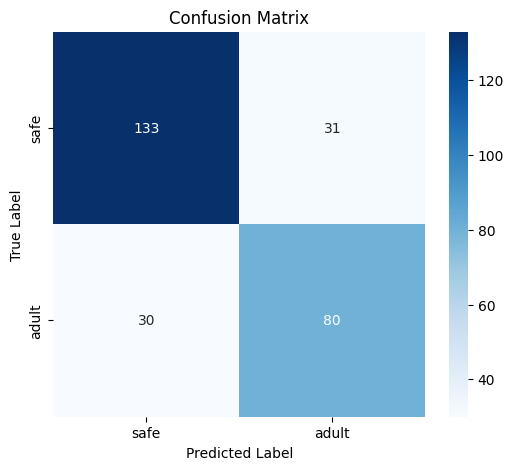


🔹 Classification Report:
              precision    recall  f1-score   support

        safe       0.82      0.81      0.81       164
       adult       0.72      0.73      0.72       110

    accuracy                           0.78       274
   macro avg       0.77      0.77      0.77       274
weighted avg       0.78      0.78      0.78       274



In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 📌 Funzione per stampare la Matrice di Confusione
def plot_confusion_matrix(model, val_loader, class_names=['safe', 'adult']):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
            labels = batch["labels"].cpu().numpy()

            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    # 📌 Generare la matrice di confusione
    cm = confusion_matrix(all_labels, all_preds)

    # 📌 Stampare la matrice di confusione
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # 📌 Stampare il report di classificazione
    print("\n🔹 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

# 📌 Chiamare la funzione dopo il training
plot_confusion_matrix(model, val_loader)